<a href="https://colab.research.google.com/github/JoshRice1/Mvc/blob/master/UseGcpData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and setup run envorment

install pytorch

In [2]:

!pip3 install torch==1.13.0+cu117 torchvision==0.14.0+cu117 torchtext==0.14.0 torchaudio==0.13.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████▊                 | 834.1 MB 1.4 MB/s eta 0:11:59tcmalloc: large alloc 1147494400 bytes == 0x3a9dc000 @  0x7f6ddf31d615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |██████████████████▊             | 1055.7 MB 1.7 MB/s eta 0:07:33tcmalloc: large alloc 1434370048 bytes == 0x7f032000 @  0x7f6ddf31d615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.13.0+cu117
0.14.0+cu117


# Setup data set files

In [5]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [6]:
PROJECT_ID = 'rcx-image-recognition-dev' # TODO (Set to your GCP Project name)
!gcloud config set project {PROJECT_ID}

BUCKET_NAME = 'reconyx-images-bucket-dev' # TODO (Set to your GCS Bucket name)
REGION = 'us-central1' #@param {type:"string"}

Updated property [core/project].


In [7]:
!mkdir data
!mkdir models

In [17]:
!rm -rf data/
!gsutil -m cp -r gs://reconyx-images-bucket-dev/simpleDataSet/data .

train_dir = 'data/train'
validation_dir = 'data/validation'

BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.Resize(224),transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.ImageFolder(train_dir,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.ImageFolder(validation_dir,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-10.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-14.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-12.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-4.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-2.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-20.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-6.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-16.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-8.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/positive-buck-18.jpg...
Copying gs://reconyx-images-bucket-dev/simpleDataSet/data/train/buck/possi

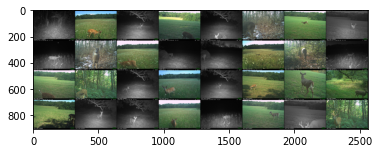

In [18]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [19]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 224, 318])
Image label dimensions: torch.Size([32])


# Setup Helpers

In [22]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [23]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 3, 224, 318])


RuntimeError: ignored

# Training

In [35]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [1]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

NameError: ignored

# Test model

In [40]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.53
